In [1]:
import pickle
import numpy as np
import torch
from torch import nn
import copy
import math
import matplotlib.pyplot as plt
import random
import torch.nn.init as init
from torch.optim.lr_scheduler import LambdaLR
import torch.nn.functional as F
import warnings
from copy import copy
from torch.utils.data import random_split
warnings.filterwarnings("ignore")
def show_images(data, num_samples=1, cols=1):
    if isinstance(data, torchvision.datasets.ImageFolder):
        plt.figure(figsize=(15,15))
        for i, img in enumerate(data):
            if i == num_samples:
                break
            plt.subplot(num_samples/cols+1, cols, i+1)
            plt.imshow(img[0])

def show_tensor_image(image):
    if len(image.shape) == 4:
        image = image[0]
    image = torch.clamp(image, -1, 1)
    plt.imshow(image.squeeze(0))

In [37]:
T = 200
max_octaves = 8
sequence_length = 128
device = torch.device("cuda")

#####################
def linear_beta_schedule(timesteps, start = 0.0001, end = 0.02):
    return torch.linspace(start, end, timesteps)


betas = linear_beta_schedule(timesteps=T).cuda()

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0).cuda()
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0).cuda()
sqrt_recip_alphas = torch.sqrt(1.0 / alphas).cuda()
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).cuda()
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod).cuda()
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod).cuda()    

def deformat_time(input):
        input = torch.tensor(input) 
        return torch.clamp(input*2000, 0)
def format_time(input):
        return input/2000
    

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cuda())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device ="cuda"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    
    return sqrt_alphas_cumprod_t.to(device)*x_0.to(device) + \
sqrt_one_minus_alphas_cumprod_t.to(device)*noise.to(device), noise.to(device) 


class Embedding(nn.Module):
    def __init__(self, in_shape, emb_shape):
        super().__init__()
        self.sems = 12
        self.octs = max_octaves
        self.sem_shape = emb_shape - 1
        self.emb_shape = emb_shape
    
        self.sem_embedding = nn.Sequential(nn.Linear(in_shape-1, self.sem_shape), nn.SiLU(),
                                        nn.Linear(self.sem_shape, self.sem_shape), nn.Tanh())
        
        self.sem_decoder = nn.Sequential(nn.Linear(self.sem_shape, self.sem_shape), nn.SiLU(),
                                        nn.Linear(self.sem_shape, in_shape-1), nn.SiLU())
        
    def encoder(self, input):
        encoded_sem = self.sem_embedding(input[..., :-1])
        return torch.cat((encoded_sem, input[..., -1:]), dim=-1)
    
    def decoder(self, input):
        decoded_sem = self.sem_decoder(input[..., :-1]).to(device)
        return torch.cat((decoded_sem, input[..., -1:]), dim=-1)
        
    def fit(self, target_loss):
        optim = torch.optim.Adam(self.parameters(), lr=0.00025)
        N = 256
        while True:
            one_hot1 = torch.eye(self.sems)
            one_hot2 = torch.eye(self.octs)
            random_values = torch.rand(N, 1)
            random_values[N//2:] *= 0.3
            random_values = format_time(random_values*2500)
            random_values[:N//4] = 0
            input = torch.cat([one_hot1[torch.randint(0, self.sems, (N,))] , one_hot2[torch.randint(0, self.octs, (N,))], random_values], dim=1)
            input = input.unsqueeze(0).to(device)
            out = self.decoder(self.encoder(input))
            loss = nn.functional.mse_loss(input, out)
            loss.backward()
            optim.step()
            optim.zero_grad()
            print(loss.item())
            if loss.item() < target_loss:
                torch.save(self.state_dict(), "./modeldata/embedding")
                break
                

In [38]:

class NoteDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, sequence_length = 128):
        training_data = pickle.load(open(data_path, 'rb'))
        self.sequence_length = sequence_length
        
        for n, track in enumerate(training_data):
            i=0
            while i < len(track[1])-1:
                time_diff = int(track[1][i+1]["start"] - track[1][i]["start"])
                if ((time_diff < 1 and (track[1][i]["notes"] == track[1][i+1]["notes"]))) or (time_diff in range(1,30)):
                    
                    training_data[n][1].remove(training_data[n][1][i])
                else:
                    i+=1
        
        for track in training_data:
            for i in reversed(range(len(track[1]))):
                track[1][i]["start"] = track[1][i]["start"] - track[1][i-1]["start"] if i != 0 else 0
                      
        
        
        skip_count = [0,0]        
        self.data = []
        self.band_idx = []#name i stores data i name
        self.bands = []#band list
        for track in training_data:
            sequence_ind = 0
            sequence_data = []
            for beat in track[1]:
                if beat["start"] < 0:
                    skip_count[0] += 1
                    continue
                    
                new_elements = beat["notes"]
                for note in new_elements:
                    if note[1] > (max_octaves-1):
                        skip_count[1] += 1
                        continue
                    new_data_point = [[0 for i in range(12)], [0 for i in range(max_octaves)]]
                    new_data_point[0][note[0]], new_data_point[1][note[1]] = 1, 1
                    new_data_point = new_data_point[0] + new_data_point[1]
                    new_data_point.append(min(beat["start"], 2500))
                    sequence_data.append(new_data_point) 
                    sequence_ind+=1
                    if sequence_ind == sequence_length:
                        self.data.append(sequence_data)
                        if track[0] not in self.bands:
                            self.bands.append(track[0])
                        self.band_idx.append(self.bands.index(track[0]))
                        sequence_data = []
                        sequence_ind = 0
        
        self.data = torch.tensor(self.data, dtype=torch.float32).to(device)
        pickle.dump(self.bands, open("./modeldata/bands", 'wb'))
        
        print("skipped:", skip_count[0]+skip_count[1], "total_bands:", len(self.bands))
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        rnd = (torch.rand(1).to(device)*-0.25) + 1.
        data = self.data[idx].clone()
        data[:, -1] = format_time(data[:,-1]*rnd)
        return data, self.bands[self.band_idx[idx]]
    
class SelfAttention(nn.Module):
    def __init__(self, channels, size1, size2, num_heads = 4):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size1 = size1
        self.size2 = size2
        self.mha = nn.MultiheadAttention(channels, num_heads, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size1 * self.size2).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size1, self.size2)
    
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False, pad=1):
        super().__init__()
        if mid_channels == None:
            mid_channels = out_channels
        self.residual = residual
        
        self.double_conv = nn.Sequential(nn.Conv2d(in_channels, mid_channels, 3, padding = pad, bias = False),
                                         nn.GroupNorm(1, mid_channels),
                                         nn.GELU(),
                                         nn.Conv2d(mid_channels, out_channels, 3, padding = pad, bias = False),
                                         nn.GroupNorm(1, out_channels))
        
    def forward(self, x):
        if self.residual:
            return F.gelu(self.double_conv(x)+x)
        else:
            return self.double_conv(x)
            
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=32, pad=1):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual = True, pad=pad),
            DoubleConv(in_channels, out_channels, pad=pad)
            
        )
        
        self.emb_layer = nn.Sequential(nn.SiLU(),
                                       nn.Linear(emb_dim, out_channels))
    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[(..., ) + (None, ) * 2]
        return x + emb
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=32):
        super().__init__()
        self.up = nn.Upsample(scale_factor = 2, mode="bilinear", align_corners = True)
        self.conv = nn.Sequential(DoubleConv(in_channels, in_channels, residual = True),
                                 DoubleConv(in_channels, out_channels, in_channels // 2))
        
        self.emb_layer = nn.Sequential(nn.SiLU(),
                                       nn.Linear(emb_dim, out_channels))
    def forward(self, x, skip_x, t):
                                
        x = self.up(x)
        x = torch.cat([x, skip_x], dim = 1)
        x = self.conv(x)
        emb = self.emb_layer(t)[(..., ) + (None, ) * 2]
        return x + emb
        
class TimeAndBandEmbedding(nn.Module):
    def __init__(self, dim_t, dim_b):
        super().__init__()
        self.dim_t = dim_t
        self.dim_b = dim_b
        self.bands_list = pickle.load(open("./modeldata/bands", 'rb'))
        self.band_compressor = nn.Sequential(nn.Linear(len(self.bands_list), self.dim_b), 
                                             nn.SiLU())

    def forward(self, time, bands):
        band_id = F.one_hot(torch.tensor([self.bands_list.index(b) for b in bands]).to("cuda"), len(self.bands_list)).to(torch.float)
        half_dim_t = self.dim_t // 2
        embeddings_t = math.log(10000) / (half_dim_t - 1)
        embeddings_t = torch.exp(torch.arange(half_dim_t, device=device) * -embeddings_t)
        embeddings_t = time[:, None] * embeddings_t[None, :]
        embeddings_t = torch.cat((embeddings_t.sin(), embeddings_t.cos()), dim=-1)
        embeddings_b = self.band_compressor(band_id)
        return torch.cat((embeddings_t, embeddings_b), dim=-1)


class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=26, band_dim = 6):
        super().__init__()
        self.encoding = TimeAndBandEmbedding(time_dim, band_dim)
        self.b_d = band_dim
        embed_dim = time_dim + band_dim
        
        self.inc = DoubleConv(c_in, 64)       #64, 128, 12
        self.down1 = Down(64, 128, embed_dim) #128, 64,6
        self.sa1 = SelfAttention(128, 64, 6)  #128, 64, 6
        self.down2 = Down(128, 256, embed_dim)#128, 32, 3
        self.sa2 = SelfAttention(256, 32, 3)  #128, 32, 3
 
        self.bot1 = DoubleConv(256, 512)
        self.sab_1 = SelfAttention(512, 32, 3, 8)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 512)
        self.sab_2 = SelfAttention(512, 32, 3, 8)
        self.bot4 = DoubleConv(512, 256) #128, 32, 3
        
        self.up1 = Up(384, 256, embed_dim) #128, 64, 3
        self.sa3 = SelfAttention(256, 64, 6)
        self.up2 = Up(320, 64, embed_dim)
        self.sa4 = SelfAttention(64, 128, 12)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)
        
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                
    
    def forward(self, x, t, b):
        cond = self.encoding(t, b)

        x1 = self.inc(x)
        x2 = self.down1(x1, cond)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, cond)
        x3 = self.sa2(x3)
        
        x3 = self.bot1(x3)
        x3 = self.sab_1(x3)
        x3 = self.bot2(x3)
        x3 = self.bot3(x3)
        x3 = self.sab_2(x3)
        x3 = self.bot4(x3)
        
        x = self.up1(x3, x2, cond)
        x = self.sa3(x)     
        x = self.up2(x, x1, cond)
        x = self.sa4(x)
        output = self.outc(x)
        return output      
    
def get_loss_comps(model, x_0, t, bands):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t, bands)
    return noise, noise_pred

@torch.no_grad()
def sample_timestep(x,t,b,temp):
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
   
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, b) / sqrt_one_minus_alphas_cumprod_t)
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise * temp
    
@torch.no_grad()
def generate(b, start_temp, end_temp):
    model.eval()
    img = torch.randn((1, 1, sequence_length, embedding.emb_shape), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 5
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        temp = start_temp + (end_temp-start_temp)*(i/T)
        img = sample_timestep(img, t, [b], temp)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize+1))
            show_tensor_image(img.detach().cpu())
    plt.show()
    model.train()
    return img
    

def prediction(input, k=1):
    input = input.squeeze(0).squeeze(0)
    sems = torch.tensor(torch.topk(input[:, :12], dim=-1, k=k).indices[:, k-1]).unsqueeze(1)
    octs =  torch.tensor(torch.topk(input[:, 12:-1], dim=-1, k=k).indices[:, k-1]).unsqueeze(1)
    times = input[:, -1].unsqueeze(-1)
    return torch.cat((sems,octs,deformat_time(times)), dim = -1).to(torch.int).to("cpu").detach().numpy()

def prediction2(input):
    input = input.squeeze(0).squeeze(0)
    sems = torch.tensor(input[:, :12].argmax(dim=-1)).unsqueeze(1)
    octs =  torch.tensor(input[:,12:12+max_octaves].argmax(dim=-1)).unsqueeze(1)
    print(octs.shape)
    times = input[:, -1].unsqueeze(-1)
    return torch.cat((sems,octs,deformat_time(times)), dim = -1).to(torch.int).to("cpu").detach().numpy()

def group_times(input, num_groups, coeff, clamp, make_time_constant):
    if make_time_constant["value"] != -1:
        out = input.copy()
        out[:, -1] = make_time_constant["value"]
        mask = input[:, -1] < make_time_constant["threshold"]
        out[mask, -1] = 0
        return out
    times = input[:, -1].flatten()
    times[times>clamp] = clamp
    value_range = max(times) - min(times)
    bin_size = value_range / num_groups
    groups = [int((time - min(times)) //bin_size )for time in times]
    
    mean_per_group = [[] for i in range(num_groups+1)]
    for g, t in enumerate(times):
        mean_per_group[int(groups[g])].append(t)
    
    mean_per_group = [sum(e)/len(e) if len(e)!= 0 else 0 for e in mean_per_group] 
    corrected_ts = [mean_per_group[i] for i in groups]
    out = [np.append(elem[:-1],int(corrected_ts[i]*coeff)) for i, elem in enumerate(input)]
    return out

    


In [42]:
batch_size = 16
def lr_lambda(epoch, max_epochs, max_lr, initial_lr, final_lr, warmup_epochs):
    
    if epoch < warmup_epochs:
        return (max_lr - initial_lr) / warmup_epochs * epoch + initial_lr
    else:
        return (final_lr + 0.5 * (max_lr - final_lr) *
                (1 + np.cos((epoch - warmup_epochs) / (max_epochs - warmup_epochs) * np.pi)))

max_epochs = 500
max_lr = 10**(-3.8)
initial_lr = 10**(-5)
final_lr = 10**(-8)
warmup_epochs = 5

#dataset = NoteDataset(data_path = "./preprocessed_data/data", sequence_length = sequence_length)

train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size
#train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



model = UNet(c_in=1, c_out=1, time_dim=30, band_dim = 2).to(device)
net_state_dict = torch.load("./modeldata/model")
model.load_state_dict(net_state_dict) 
optim = torch.optim.Adam(model.parameters(), lr=1, weight_decay=0.001)
scheduler = LambdaLR(optim, lr_lambda=lambda epoch: lr_lambda(epoch, max_epochs, max_lr, initial_lr, final_lr, warmup_epochs))

In [ ]:
scheduler.step()
#optim = torch.optim.Adam(model.parameters(), lr=10**(-4.5), weight_decay=0.0007)
epochs = 15000

def val():
    model.eval()
    losses = []
    for images, bands in val_loader:
        images = images.unsqueeze(1)
        images = embedding.encoder(images)
        t = torch.randint(0, T, (images.shape[0],), device=device).long()
        target, prediction = get_loss_comps(model, images, t, bands)
        loss = F.mse_loss(prediction, target)
        losses.append(loss.item())
    model.train()
    loss = sum(losses)/len(losses)
    print(f"Validation loss: {loss} ")
    return loss
            
def train():
    for epoch in range(epochs):
        losses = []
        val_losses = [99,99,99]
        for images, bands in data_loader:
            images = images.unsqueeze(1)
            images = embedding.encoder(images)
            optim.zero_grad()
            t = torch.randint(0, T, (images.shape[0],), device=device).long()
            target, prediction = get_loss_comps(model, images, t, bands)
            loss = F.mse_loss(prediction, target)
            losses.append(loss.item())
            loss.backward()
            optim.step()
        scheduler.step()
            
        print(f"Epoch {epoch} | Loss: {sum(losses)/len(losses)} ")
        if epoch % 150 == 0 and epoch != 0:      
            torch.save(model.state_dict(), "./modeldata/model")
        if epoch % 2 == 0 and epoch != 0:      
            val_losses.append(val())
            if val_losses[-1] > val_losses[-2] > val_losses[-3] > val_losses[- 4]:
                torch.save(model.state_dict(), "./modeldata/model")
                print("Validation loss increasing")
                break
            
train()   #

Epoch 0 | Loss: 0.22418310622620674 
Epoch 1 | Loss: 0.14515228069010583 
Epoch 2 | Loss: 0.12092918693265728 
Validation loss: 0.11281970921637756 
Epoch 3 | Loss: 0.11198528416326824 
Epoch 4 | Loss: 0.10440807896559588 
Validation loss: 0.11119976619790707 
Epoch 5 | Loss: 0.10066394545208976 
Epoch 6 | Loss: 0.09651848817429015 
Validation loss: 0.09014363942800888 
Epoch 7 | Loss: 0.09357208799826734 
Epoch 8 | Loss: 0.09245146891343912 
Validation loss: 0.09291121137461492 
Epoch 9 | Loss: 0.08958113291620753 
Epoch 10 | Loss: 0.08811482900170652 
Validation loss: 0.08567049467403974 
Epoch 11 | Loss: 0.08667184969495612 
Epoch 12 | Loss: 0.08566925270155869 
Validation loss: 0.09022263417552624 
Epoch 13 | Loss: 0.08497196979081358 
Epoch 14 | Loss: 0.08409189889278576 
Validation loss: 0.08156980081860508 
Epoch 15 | Loss: 0.0849722380188244 
Epoch 16 | Loss: 0.08438488472437927 
Validation loss: 0.08681960270873137 
Epoch 17 | Loss: 0.0826635200899976 
Epoch 18 | Loss: 0.08157

Validation loss: 0.06892823614180088 
Epoch 145 | Loss: 0.0756580884113396 
Epoch 146 | Loss: 0.07479600080480898 
Validation loss: 0.0789091805262225 
Epoch 147 | Loss: 0.07371175552910293 
Epoch 148 | Loss: 0.07386564180070093 
Validation loss: 0.07095511949488095 
Epoch 149 | Loss: 0.07464859806683682 
Epoch 150 | Loss: 0.07461983062156284 
Validation loss: 0.0745400116512818 
Epoch 151 | Loss: 0.07458262987975173 
Epoch 152 | Loss: 0.07470828195223371 
Validation loss: 0.07373263034969568 
Epoch 153 | Loss: 0.07440356918404462 
Epoch 154 | Loss: 0.07362672123873165 
Validation loss: 0.07161784092230457 
Epoch 155 | Loss: 0.07397121193868514 
Epoch 156 | Loss: 0.0734002013079367 
Validation loss: 0.07347978185862303 
Epoch 157 | Loss: 0.07473085680621043 
Epoch 158 | Loss: 0.07440885715897529 
Validation loss: 0.07194367496828948 
Epoch 159 | Loss: 0.0745317042904785 
Epoch 160 | Loss: 0.07424399882682976 
Validation loss: 0.07132643973454833 
Epoch 161 | Loss: 0.07480283658453868 


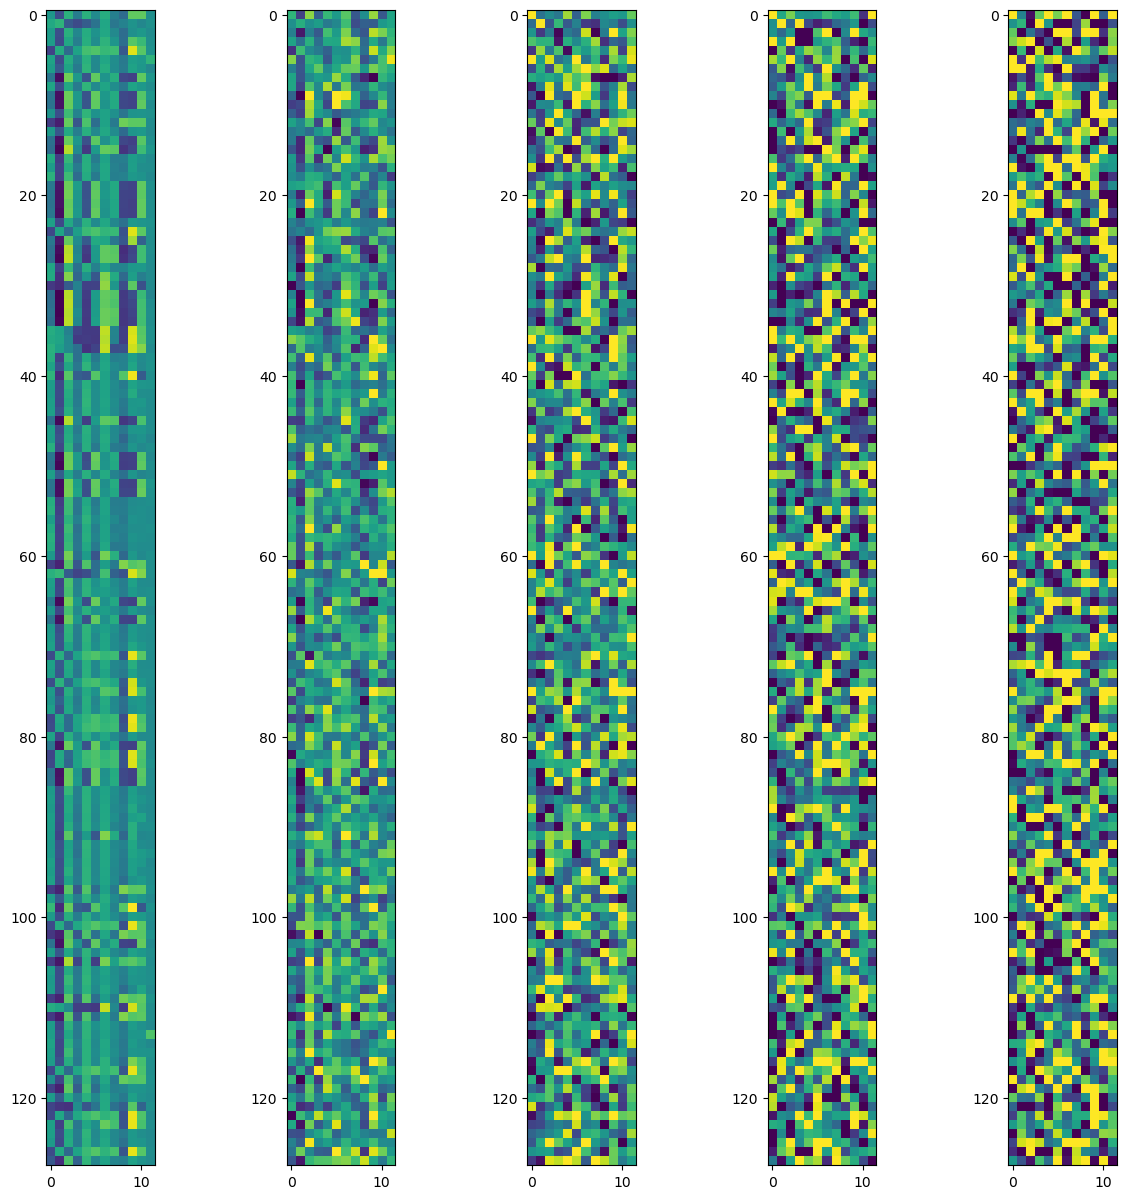

torch.Size([128, 1])


In [71]:
pred = generate("tech", start_temp=1, end_temp=1)
pred = embedding.decoder(pred)
pred = prediction2(pred)


In [77]:
out = group_times(pred, num_groups=4, coeff=2.3, clamp=600, 
                  make_time_constant = {"value": -1, "threshold": 30}) #if make_time_constant["value"]!=-1 replaces all times, except those below threshold, which are set to 0
#out = pred                                                                                                    
with open("./outputs/generated_sequence", "wb") as f:
    pickle.dump(out, f)
out

[array([  3,   6, 142]),
 array([  2,   4, 142]),
 array([  3,   5, 142]),
 array([  3,   6, 142]),
 array([  8,   4, 142]),
 array([   3,    5, 1380]),
 array([  3,   4, 142]),
 array([  7,   4, 402]),
 array([  3,   4, 142]),
 array([  7,   4, 402]),
 array([  7,   4, 142]),
 array([  4,   6, 142]),
 array([  0,   6, 142]),
 array([  5,   4, 142]),
 array([  7,   4, 142]),
 array([  7,   3, 402]),
 array([  2,   4, 142]),
 array([  3,   7, 142]),
 array([  2,   6, 142]),
 array([  7,   5, 142]),
 array([  7,   6, 142]),
 array([  7,   4, 142]),
 array([  7,   7, 142]),
 array([  3,   5, 142]),
 array([  8,   4, 142]),
 array([  1,   5, 142]),
 array([  7,   3, 142]),
 array([  7,   3, 142]),
 array([  2,   4, 142]),
 array([  2,   3, 142]),
 array([ 10,   3, 142]),
 array([  7,   3, 142]),
 array([  7,   3, 142]),
 array([  7,   3, 142]),
 array([  7,   3, 142]),
 array([ 11,   3, 142]),
 array([ 11,   3, 142]),
 array([ 11,   2, 142]),
 array([  2,   5, 142]),
 array([  6,   4, 402]

In [25]:
torch.save(model.state_dict(), "./modeldata/model")

#model = model = UNet().to(device)

#net_state_dict = torch.load("./modeldata/model")
#model.load_state_dict(net_state_dict) 

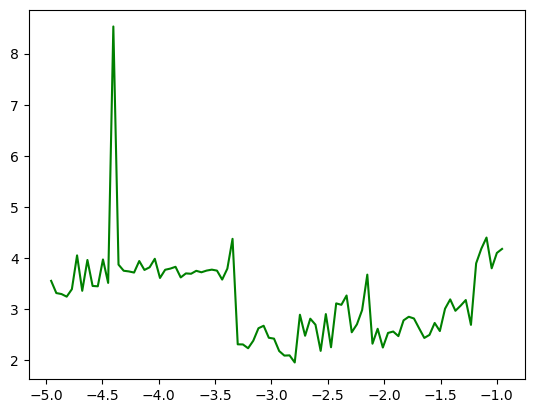

In [542]:

#plt.plot(x, [i for i in y["time"]], color = "blue")
plt.plot(x, y["sem"], color = "green")

In [27]:
embedding.encoder(dataset.data[5])

tensor([[-5.0129e-01, -5.2427e-01, -5.4536e-01,  ...,  4.1985e-01,
         -2.6887e-01,  1.6000e+02],
        [ 1.5050e-01, -3.0137e-01,  2.4034e-01,  ...,  8.0199e-02,
          9.5078e-02,  1.6000e+02],
        [-5.0129e-01, -5.2427e-01, -5.4536e-01,  ...,  4.1985e-01,
         -2.6887e-01,  1.6000e+02],
        ...,
        [ 1.4366e-01, -4.2049e-01,  4.8833e-01,  ...,  2.5156e-01,
         -6.6933e-02,  2.4000e+02],
        [ 3.0876e-01, -6.2977e-01,  4.7241e-01,  ...,  8.8324e-01,
         -3.2433e-01,  0.0000e+00],
        [ 1.5345e-01, -3.1384e-01,  2.2727e-01,  ...,  2.2208e-01,
          4.0555e-02,  0.0000e+00]], device='cuda:0', grad_fn=<CatBackward0>)

In [29]:
dataset.bands

['tech', 'other', 'black']